# 1. 600명의 고객을 VIP가능성 이탈 가능성으로 분류하기(k-means)

## 전처리

In [1]:
!pip install koreanize_matplotlib

In [2]:
import pandas as pd
import datetime as dt
import koreanize_matplotlib

In [3]:
# ============================================
# 1. 데이터 불러오기 (CSV: 공백 구분)
# ============================================
df = pd.read_csv('/content/drive/MyDrive/project2/customer.csv', sep='\t')



print("✅ 데이터 샘플:\n", df.head())
print("\n✅ 컬럼 타입:\n", df.dtypes)

# ============================================
# 2. 날짜 변환 & Recency 계산
# ============================================
today = df['last_rental_date'].max()

df['last_rental_date'] = pd.to_datetime(df['last_rental_date'], errors='coerce')
today = dt.datetime.now()
df['Recency'] = (today - df['last_rental_date']).dt.days


print(df.columns)
print(df.head())
print(df.info())

✅ 데이터 샘플:
    customer_id     last_rental_date  total_rentals  total_payment
0          148  2005-08-23 05:57:04             46         216.54
1          526  2005-08-23 22:21:03             45         221.55
2          144  2005-08-23 12:43:30             42         195.58
3          236  2006-02-14 15:16:03             42         175.58
4           75  2006-02-14 15:16:03             41         155.59

✅ 컬럼 타입:
 customer_id           int64
last_rental_date     object
total_rentals         int64
total_payment       float64
dtype: object
Index(['customer_id', 'last_rental_date', 'total_rentals', 'total_payment',
       'Recency'],
      dtype='object')
   customer_id    last_rental_date  total_rentals  total_payment  Recency
0          148 2005-08-23 05:57:04             46         216.54     7273
1          526 2005-08-23 22:21:03             45         221.55     7272
2          144 2005-08-23 12:43:30             42         195.58     7272
3          236 2006-02-14 15:16:03         

## RFM 스코어 계산

In [4]:
# 3. RFM 스코어 계산
# ============================================
df['R_score'] = pd.qcut(df['Recency'].rank(method='first'), 5, labels=[5,4,3,2,1])
df['F_score'] = pd.qcut(df['total_rentals'].rank(method='first'), 5, labels=[1,2,3,4,5])
df['M_score'] = pd.qcut(df['total_payment'].rank(method='first'), 5, labels=[1,2,3,4,5])

df['RFM_Score'] = df[['R_score','F_score','M_score']].astype(int).sum(axis=1)
df['RFM_Score']

,RFM_Score
0,12
1,14
2,14
3,15
4,15
...,...
594,3
595,4
596,3
597,3


## RFM 기각 > K-Means
RFM에서 R에 큰 의미가 없으므로 (최근과 처음 대여일의 기간이 9개월 차이밖에 안 남)  
군집분석으로 고객 다시 분류

## kmeans

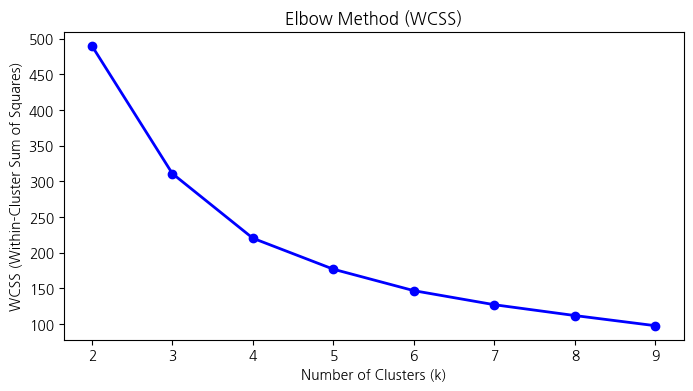

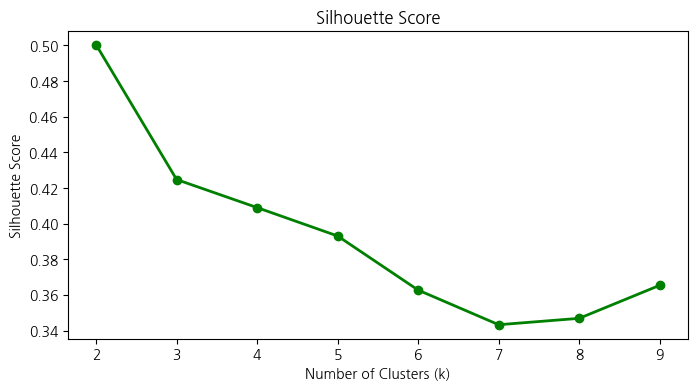


✅ Elbow Method 참고 후, Silhouette 기준 최적 k는: 2


In [5]:
# 최적의 k 찾는법

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# ============================================
# 1. 특징 선택 (Recency는 제거, F & M 사용)
# ============================================
features = df[['total_rentals', 'total_payment']]

# 데이터 스케일링
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# ============================================
# 1. Elbow Method (Within-Cluster Sum of Squares)
# ============================================
wcss = []
silhouette_scores = []
K_range = range(2, 10)  # 2~9까지 확인

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)  # 클러스터 내 제곱합
    # 실루엣 점수는 k=2 이상일 때만 가능
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# ============================================
# 2. Elbow Plot
# ============================================
plt.figure(figsize=(8, 4))
plt.plot(K_range, wcss, 'bo-', linewidth=2)
plt.title('Elbow Method (WCSS)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(K_range)
plt.show()

# ============================================
# 3. Silhouette Score Plot
# ============================================
plt.figure(figsize=(8, 4))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2)
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range)
plt.show()

# ============================================
# 4. 최적 k 추천
# ============================================
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\n✅ Elbow Method 참고 후, Silhouette 기준 최적 k는: {best_k}")


결국 이탈 가능성이 있는 고객을 찾기 위한 것이니
논리적으로 k는 2가 적당  
실루엣 기법으로도 k가 최적이라 나옴
> 따라서 k = 2


✅ 클러스터별 평균값:
          total_rentals  total_payment
Cluster                              
0            31.050360     133.221871
1            23.090343      94.613333


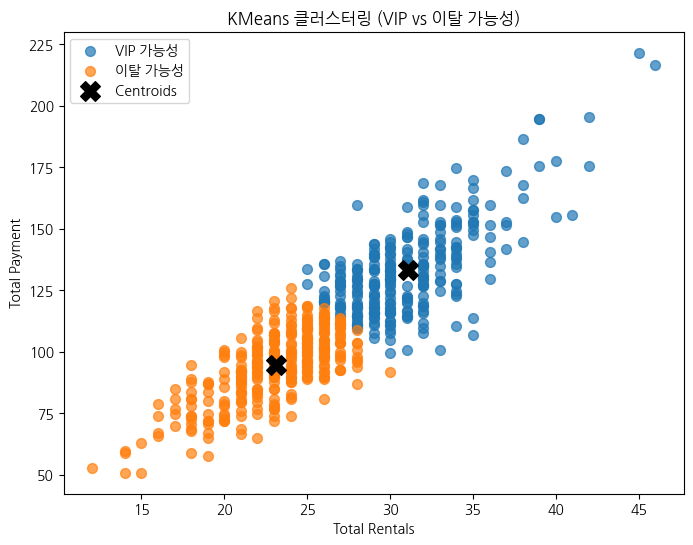

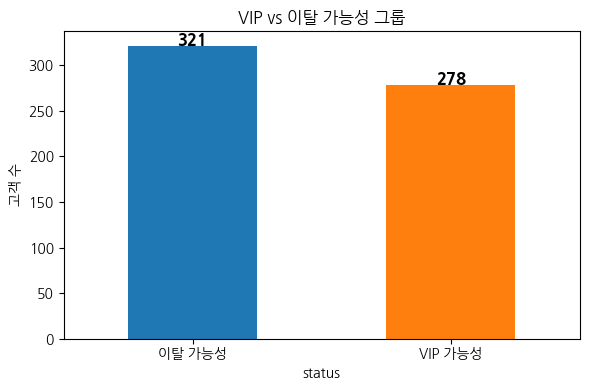

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# ============================================
# 2. KMeans 클러스터링 (k=2)
# ============================================
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# ============================================
# 3. 클러스터별 평균값 확인
# ============================================
cluster_summary = df.groupby('Cluster')[['total_rentals', 'total_payment']].mean()
print("\n✅ 클러스터별 평균값:\n", cluster_summary)

# VIP 가능성 높은 클러스터 = (F+M 평균이 높은 클러스터)
vip_cluster = cluster_summary[['total_rentals', 'total_payment']].mean(axis=1).idxmax()
df['status'] = df['Cluster'].apply(lambda x: 'VIP 가능성' if x == vip_cluster else '이탈 가능성')

# ============================================
# 4. 시각화 1: Scatter Plot (Rentals vs Payment)
# ============================================
colors = {'VIP 가능성': '#1f77b4', '이탈 가능성': '#ff7f0e'}
plt.figure(figsize=(8, 6))

for status, group in df.groupby('status'):
    plt.scatter(group['total_rentals'], group['total_payment'],
                label=status, alpha=0.7, s=50, c=colors[status])

# 클러스터 중심점 (원래 값으로 복원)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1],
            s=200, c='black', marker='X', label='Centroids')

plt.xlabel('Total Rentals')
plt.ylabel('Total Payment')
plt.title('KMeans 클러스터링 (VIP vs 이탈 가능성)')
plt.legend()
plt.show()

# ============================================
# 5. 시각화 2: Bar Chart (VIP vs 이탈 가능성 고객 수)
# ============================================
status_counts = df['status'].value_counts()

plt.figure(figsize=(6, 4))
ax = status_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('VIP vs 이탈 가능성 그룹')
plt.ylabel('고객 수')
plt.xticks(rotation=0)

# 막대 위에 값 표시
for i, count in enumerate(status_counts):
    plt.text(i, count + 1, str(count), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## 결과 요약  
클러스터 평균값

| Cluster | total\_rentals | total\_payment |
| ------- | -------------- | -------------- |
| 0       | **31.05**      | **133.22**     |
| 1       | 23.09          | 94.61          |


인사이트
1. VIP 가능성 고객 (Cluster 0)
평균 대여 횟수: 31.05회 (이탈 대비 +34%↑)

평균 결제 금액: 133.22달러 (이탈 대비 +41%↑)

충성도가 높은 핵심 고객군으로 볼 수 있음


그룹 분포  
이탈 가능성: 341명 (57%)

VIP 가능성: 258명 (43%)



## KPI제안
VIP 전환율: 50% 이상

이탈 그룹에서 최소 15% 재활성화

구독 유지율: 3개월 이상 80% 달성


## 전략 도출
### 이탈 방지 전략
- 가격 혜택
- 개인화된 마케팅
- 이탈 가능성 있는 고객에게만 알림 활용


# 2. 가격책정전략
구독료를 측정하기 위해

전체 고객의 월평균 지출액 (평균값)

VIP 가능성 그룹의 월평균 지출액 (평균값)

이탈 가능성 그룹의 월평균 지출액 (평균값)

위의 총 3가지를 비교해봄

Merge 후 행 개수: 599

✅ 전체 고객 월평균 지출액: 30.94
✅ VIP 가능성 그룹 월평균 지출액: 36.5
✅ 이탈 가능성 그룹 월평균 지출액: 26.13

📊 구독료 시나리오 표:
      구독료 시나리오    월평균 지출액
0       전체 평균  30.944039
1  VIP 가능성 그룹  36.499565
2   이탈 가능성 그룹  26.132712


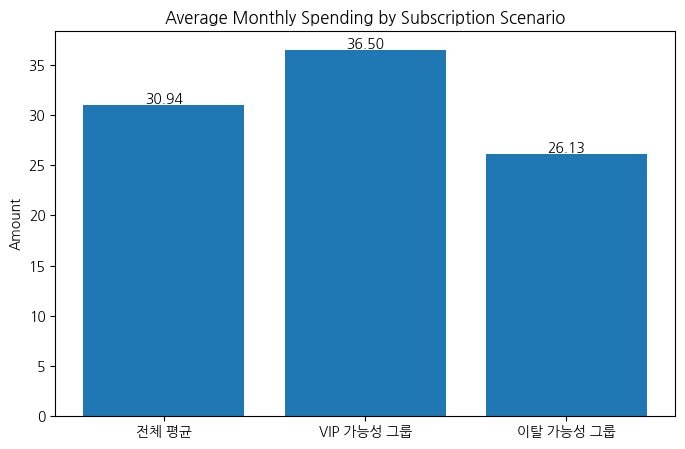

In [7]:
# ================================================
# 1. 월평균 지출액 CSV 로드
# ================================================
payment_df = pd.read_csv('/content/drive/MyDrive/project2/ttt.csv', sep='\s+')

# 컬럼 타입 변환
payment_df['customer_id'] = payment_df['customer_id'].astype(int)
payment_df['avg_monthly_payment'] = payment_df['avg_monthly_payment'].astype(float)

# ================================================

# 2. 클러스터링 결과 df에서 customer_id, status, total_rentals 추출
df['customer_id'] = df['customer_id'].astype(int)
cluster_df = df[['customer_id', 'status', 'total_rentals']]  # total_rentals 추가

# 3. Merge
merged_df = pd.merge(payment_df, cluster_df, on='customer_id', how='inner')
print("Merge 후 행 개수:", merged_df.shape[0])

# ================================================
# 4. 평균 계산
overall_avg = merged_df['avg_monthly_payment'].mean()
vip_avg = merged_df[merged_df['status'] == 'VIP 가능성']['avg_monthly_payment'].mean()
churn_avg = merged_df[merged_df['status'] == '이탈 가능성']['avg_monthly_payment'].mean()


print("\n✅ 전체 고객 월평균 지출액:", round(overall_avg, 2))
print("✅ VIP 가능성 그룹 월평균 지출액:", round(vip_avg, 2))
print("✅ 이탈 가능성 그룹 월평균 지출액:", round(churn_avg, 2))


# ================================================
# 5. 발표용 표
# ================================================
result = pd.DataFrame({
    '구독료 시나리오': ['전체 평균', 'VIP 가능성 그룹', '이탈 가능성 그룹'],
    '월평균 지출액': [overall_avg, vip_avg, churn_avg]
})
print("\n📊 구독료 시나리오 표:\n", result)

# ================================================
# 6. 시각화
# ================================================
plt.figure(figsize=(8, 5))
plt.bar(result['구독료 시나리오'], result['월평균 지출액'])
plt.title('Average Monthly Spending by Subscription Scenario') #구독료 시나리오별 월평균 지출액
plt.ylabel('Amount') #금액
for i, v in enumerate(result['월평균 지출액']):
    plt.text(i, v + 0.2, f"{v:.2f}", ha='center', fontsize=10)
plt.show()


✅ 실제 전체 고객 1회 대여당 평균 금액: 4.2
✅ 실제 VIP 가능성 그룹 1회 대여당 평균 금액: 4.29
✅ 실제 이탈 가능성 그룹 1회 대여당 평균 금액: 4.1


(0.0, 5.29)

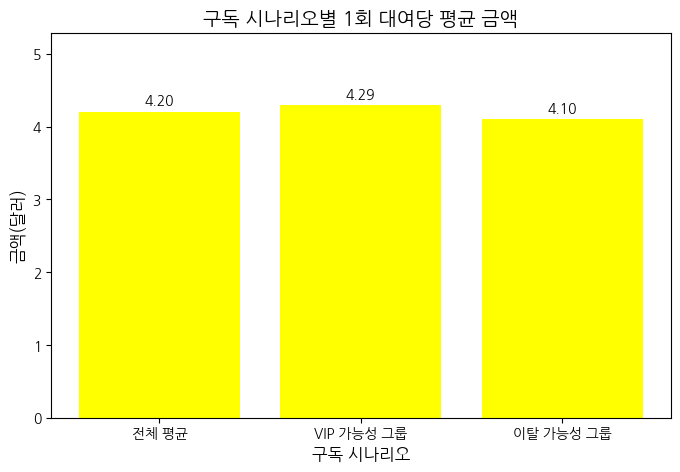

In [8]:
#1회 대여당 평균금액
# ================================================
overall_true = merged_df['total_payment'].sum() / merged_df['total_rentals'].sum()

vip_true = (
    merged_df[merged_df['status'] == 'VIP 가능성']['total_payment'].sum() /
    merged_df[merged_df['status'] == 'VIP 가능성']['total_rentals'].sum()
)

churn_true = (
    merged_df[merged_df['status'] == '이탈 가능성']['total_payment'].sum() /
    merged_df[merged_df['status'] == '이탈 가능성']['total_rentals'].sum()
)

print("\n✅ 실제 전체 고객 1회 대여당 평균 금액:", round(overall_true, 2))
print("✅ 실제 VIP 가능성 그룹 1회 대여당 평균 금액:", round(vip_true, 2))
print("✅ 실제 이탈 가능성 그룹 1회 대여당 평균 금액:", round(churn_true, 2))


#시각화
values = [round(overall_true, 2),round(vip_true, 2),round(churn_true, 2)]

plt.figure(figsize=(8, 5))
plt.bar( ['전체 평균', 'VIP 가능성 그룹', '이탈 가능성 그룹'],values,color='yellow')
plt.title('구독 시나리오별 1회 대여당 평균 금액', fontsize=14)
plt.xlabel('구독 시나리오', fontsize=12)
plt.ylabel('금액(달러)', fontsize=12)

# 값 표시
for i, v in enumerate(values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)

  # y축 범위 설정
plt.ylim(0, max(values) + 1)

## 결론
1. 고객 월평균 지출액이 약 30달러, 대여 횟수가 약 27회로 고객 충성도가 높은 것을 알 수 있음
2. 가격 책정에 있어서 구독제 세분화를 통해 VIP전용으로 비싸게 구독료를 측정 할 수 있다는 인사이트를 도출

## 전략 도출
구독 서비스를 도입함에 있어 구독제 세분화를 통해 고객 충성도가 높은 그룹에 비싼 구독료 부과를 하자 (단, 그에 맡는 혜택 제공 필수)